In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

tf.enable_eager_execution()

from DataStores.Trajectory import Trajectory, Field
from Hawkes.Hawkes import Hawkes

tf.random.set_random_seed(0)

In [7]:
# construct our process and synthetic data
label_set = tf.convert_to_tensor([0, 1], dtype=tf.int32)
times = tf.convert_to_tensor([1., 2.5, 5, 9.], dtype=tf.float32)
labels = tf.convert_to_tensor([0, 1, 0, 1], dtype=tf.int32)
fields = {
    "times" : Field(values=times, continuous=True, space=(0., 10.)),
    "labels" : Field(values=labels, continuous=False, space=label_set)
}
traj = Trajectory(fields, tau=0.1)
hp = Hawkes(len(label_set), [1, 3, 4])

In [11]:
# Gradient Descent
eta = 100
scores = []

# track the INTENSITIES, how am I going to plot this exactly?
# I need two poINTS per TIME(one with the previous int and the new one)
intensities0 = []
intensities1 = []
alltimes = []

while len(scores) < 10:
    totalllh = 0
    ints0 = []
    ints1 = []
    times = []
    hp.resetstate()
    for time_slice in traj:
        with tf.GradientTape() as tape:
            intensities = hp(time_slice)
            #Add the old INTS to get a stepwise constant
            if ints0:
                ints0.append(ints0[-1])
                ints1.append(ints1[-1])
                times.append(time_slice.time.numpy())
                
            #Add the new INTENSITIES
            ints0.append(intensities.numpy()[0])
            ints1.append(intensities.numpy()[1])
            times.append(time_slice.time.numpy())
            #print(INTS)
            llh = hp.calcsegnegllh(intensities, time_slice)
        gradients = tape.gradient(llh, hp.parameters)
        totalllh += llh
        hp.applygradients(eta, gradients[0], gradients[1])
    print("total llh for iteration {} is {}".format(len(scores), totalllh))
    intensities0.append(ints0)
    intensities1.append(ints1)
    alltimes.append(times)
    scores.append(totalllh.numpy())


total llh for iteration 0 is -218.3661651611328
total llh for iteration 1 is -446.4776306152344
total llh for iteration 2 is -448.4248962402344
total llh for iteration 3 is -445.6493835449219
total llh for iteration 4 is -444.6694641113281
total llh for iteration 5 is -448.9563293457031
total llh for iteration 6 is -445.0821533203125
total llh for iteration 7 is -445.5363464355469
total llh for iteration 8 is -445.56561279296875
total llh for iteration 9 is -446.2393798828125


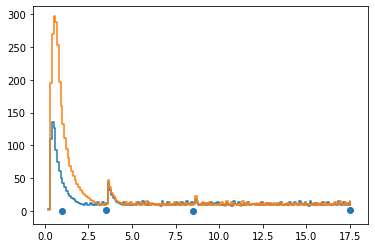

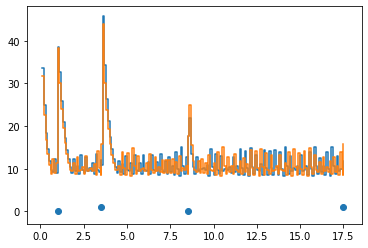

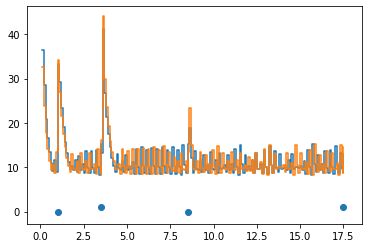

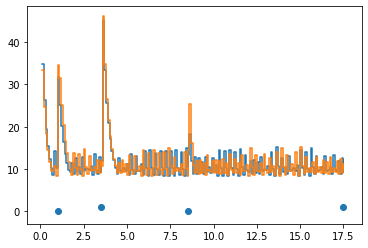

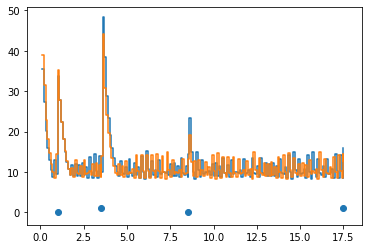

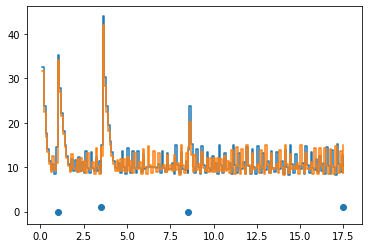

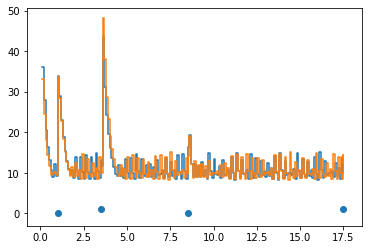

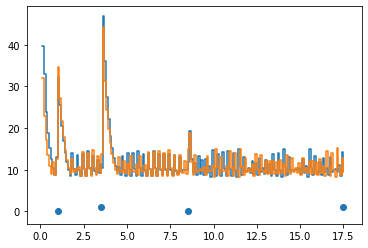

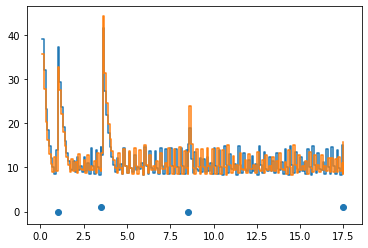

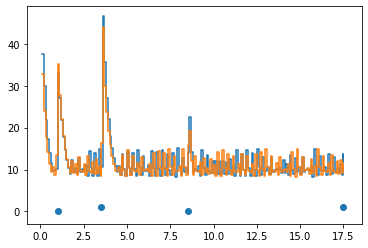

In [12]:
# plot results
X = []
Y = []
for time_slice in traj:
    l = time_slice.label.numpy()
    if l != -1:
        X.append(time_slice.time.numpy())
        Y.append(l)

for i, times in enumerate(alltimes):
    plt.close()
    plt.plot(times, intensities0[i])
    plt.plot(times, intensities1[i])
    plt.scatter(X, [v for v in Y])
    plt.pause(0.5)
    plt.close()

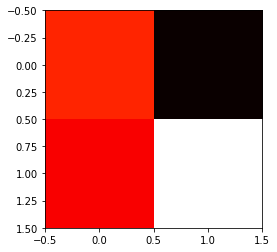

In [13]:
#Check the heat map generated by the influence matrix

str = tf.reduce_sum(hp.parameters[0], axis=2)
plt.imshow(str, interpolation='nearest')
plt.show()
# label 0 triggers label 1 (although this was random data so don't read into this)